This notebook contains the final version of each core step in this project (except our stand-alone Hinode analysis, which is in a separate notebook) and produces all figures in the paper.

Also included are some additional plots and analysis that didn't make it into the paper, or that support claims made in the paper.

Note: many "core" functions, those functions that have been used over and over in a number of notebooks over the course of this project, are in `base.py` so they can be imported into each notebook, and that is where the final versions of those functions lie. The code in this notebook, which uses `base.py`, is "one-off" code, mostly that code which produces plots or fits. Some of those fitted functions were then copied into `base.py`.

# Loading and setup

In [1]:
import astropy.constants as consts
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import rcParams
from matplotlib.colors import LogNorm
import numpy as np
from scipy.spatial import Delaunay
import scipy.stats

import base

sigma_sb = consts.sigma_sb.cgs.value

rcParams['font.serif'] = ['CMU Serif']
rcParams['font.family'] = ['serif']
rcParams['text.usetex'] = True
text_size = 9
rcParams['axes.labelsize'] = text_size
rcParams['xtick.labelsize'] = text_size
rcParams['ytick.labelsize'] = text_size
rcParams['legend.fontsize'] = text_size
rcParams['font.size'] = text_size

FIG_WIDTH = 3.6
WIDE_FIG_WIDTH = FIG_WIDTH * 513 / 242

In [2]:
# If true, paper plots are saved to files (as well as displayed)
save_plots = False

Make the catalog cuts described in Section 2 of the paper.
Note that a `has_H` filter has already been performed within `base.py`.

In [3]:
raw_catalog = base.load_catalog(raw=True)
catalog = raw_catalog[raw_catalog['has_H']]

print("Size of Bastien (2016) catalog:", len(raw_catalog))
print("# stars also in Berger (2020):", len(catalog))

cat = catalog[catalog['has_L']]

print("# stars also in Zong (2018):", len(cat))

cat = cat[cat['loggH'] > 2.5]
cat = cat[cat['TeffH'] < 7500]

print("# stars left after cuts:", len(cat))

Z = base.FeH_to_Z(cat['FeH'])

Size of Bastien (2016) catalog: 27628
# stars also in Berger (2020): 26780
# stars also in Zong (2018): 18773
# stars left after cuts: 16992


# Calculating Mach Numbers

## Determining C

This is the analysis of Section 3.4 of the paper

We assume the total convective flux through a star near its surface can be written as $F_C = C \rho v^3 = \sigma T^4$, where $\rho v^3$ is a standard scaling from mixing length theory and $C$ is the proportionality constant relating convective flux to the star's total energy flux.

We use the data of Tremblay et al. (2013) to compute C for their grid of simulations, and fit those C values to predict a C value for each Kepler star.

In [4]:
T_eff_T, logg_T, FeH_T, Ma_T, log_rho_T = np.genfromtxt("orig_data/Tremblay2013.txt", skip_header=2, 
                                                        usecols=(0, 1, 2, 7, 8), unpack=True)
rho_T = 10**log_rho_T

# Exclude white dwarfs, for which no [Fe/H] value is provided
ok = np.isfinite(FeH_T)

T_eff_T = T_eff_T[ok]
rho_T = rho_T[ok]
logg_T = logg_T[ok]
FeH_T = FeH_T[ok]
Ma_T = Ma_T[ok]

del ok, log_rho_T

# Convert Ma to a vertical-component Ma
Ma_T /= np.sqrt(3)

In [5]:
total_flux = sigma_sb * (T_eff_T)**4
v = Ma_T * base.c_s(T_eff_T)
convective_flux_kinda = rho_T * v**3
C = total_flux / convective_flux_kinda

### Our computed $C$ values: Paper Figure 3

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


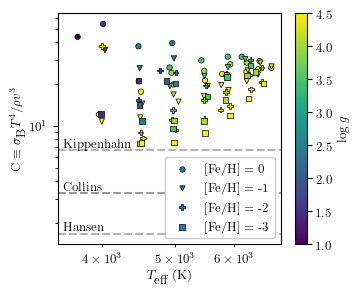

In [6]:
plt.figure(figsize=(FIG_WIDTH, 3))

for i, marker in zip(range(0, -4, -1), ['o', 'v', 'P', 's']):
    plt.scatter(T_eff_T[FeH_T == i], C[FeH_T == i], c=logg_T[FeH_T == i],
                label=f"[Fe/H] = {i}", marker=marker, s=15,
                vmin=logg_T.min(), vmax=logg_T.max(), cmap='viridis',
                edgecolors='black', linewidths=0.5)

plt.colorbar().set_label("log $g$")
plt.legend(loc='lower right', framealpha=1)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$T_\textrm{eff}$ (K)")
plt.ylabel(r"C $\equiv \sigma_\textrm{B} T^4 / \rho v^3$")

plt.axhline(3.3, linestyle='--', color='k', alpha=.4)
plt.axhline(6.67, linestyle='--', color='k', alpha=.3)
plt.axhline(1.67, linestyle='--', color='k', alpha=.3)
plt.text(3550, 3.3 * 1.05, "Collins")
plt.text(3550, 6.67 * 1.05, "Kippenhahn")
plt.text(3550, 1.67 * 1.05, "Hansen")

plt.xlim(plt.xlim()[0]*.97, None)

if save_plots:
    plt.savefig("paper/figures/C_cf_mlt.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

### Our fitted $C$ scaling: Paper Figure 4

Produce the fitted $C$ scaling:

In [7]:
def fitted_C_fcn(x, coeff, T_exp, logg_exp, FeH_exp):
    return coeff * x[0] ** T_exp * (10**x[1]) ** logg_exp * (10**x[2]) ** FeH_exp
popt, _ = scipy.optimize.curve_fit(fitted_C_fcn, np.vstack((T_eff_T, logg_T, FeH_T)), C, p0=[1, 1, 1, 1])
print("Fitted fcn: C = {:.3e} * T^{:.3f} * g^{:.3f} * [Fe/H]^{:.4f}".format(*popt))
print("Solar C = {:.3f}".format(fitted_C_fcn((base.T_sun, base.logg_sun, 0), *popt)))

Fitted fcn: C = 6.086e-04 * T^1.406 * g^-0.157 * [Fe/H]^0.0975
Solar C = 23.648


This is our fitted function for C and is incorporated into `base.calc_Ma()`. For all Kepler stars, we will compute the Mach number as $Ma = v / c_s$, with $v$ extracted from $\sigma T^4 = C \rho v^3$, as described in the paper.

Now let's look at that function:

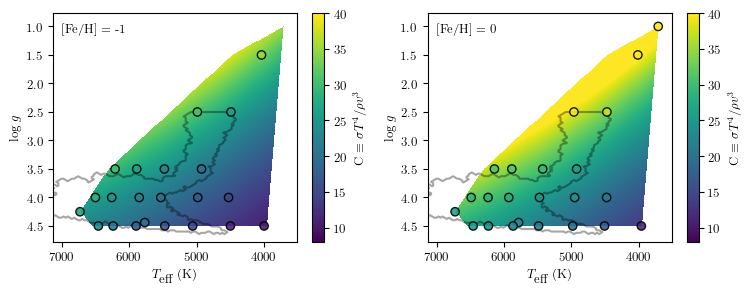

In [8]:
T_vals = np.linspace(T_eff_T.min(), T_eff_T.max(), 200)
logg_vals = np.linspace(logg_T.min(), logg_T.max(), 200)
T_grid, logg_grid = np.meshgrid(T_vals, logg_vals)

def plot_fit(C_grid, vmin=8, vmax=40, cmap='viridis', only_FeH=None):
    # We'll only plot our fit within the convex hull of the points being fit, so as to avoid
    # unseemly extrapolation off the corners of the plot where the fit won't be used anyway
    hull = Delaunay(np.vstack((T_eff_T, logg_T)).T)
    
    p = np.vstack((T_grid.flatten(), logg_grid.flatten())).T
    out_of_bounds = hull.find_simplex(p) < 0
    out_of_bounds = out_of_bounds.reshape(logg_grid.shape)
    C_grid[out_of_bounds] = np.nan
    
    plt.imshow(C_grid, vmin=vmin, vmax=vmax, cmap=cmap,
              extent=(T_vals.min(), T_vals.max(), logg_vals.max(), logg_vals.min()),
              aspect='auto', interpolation='nearest')
    plt.colorbar().set_label(r"C $\equiv \sigma T^4 / \rho v^3$")
    
    if only_FeH is not None:
        filter = FeH_T == only_FeH
    else:
        # Don't filter anything
        filter = T_eff > 0
    
    plt.scatter(T_eff_T[filter], logg_T[filter], c=C[filter],
                alpha=0.9, vmin=vmin, vmax=vmax,
                edgecolors="black", cmap=cmap,
                zorder=3)

    base.outline_data(cat=cat, alpha=0.35)

    plt.xlim(7135, 3510)
    plt.ylim(4.78, 0.77)
    plt.xlabel(r"$T_\textrm{eff}$ (K)")
    plt.ylabel("log $g$")

plt.figure(figsize=(WIDE_FIG_WIDTH, 3))

for i, FeH_val in enumerate([-1, 0]):
    plt.subplot(121 + i)
    
    C_grid = fitted_C_fcn(np.vstack((T_grid.flatten(), logg_grid.flatten(), [FeH_val] * logg_grid.size)), *popt).reshape(T_grid.shape)
    plot_fit(C_grid, only_FeH=FeH_val)
    plt.text(7000, 1.1, "[Fe/H] = {}".format(FeH_val))

plt.tight_layout()
if save_plots:
    plt.savefig("paper/figures/C-fit.pdf", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

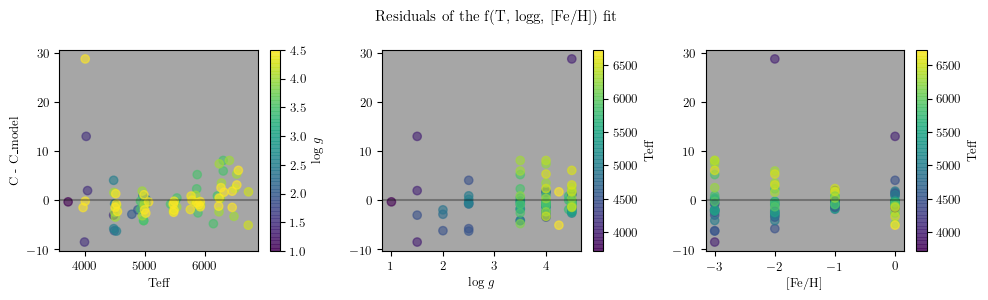

In [9]:
plt.figure(figsize=(10,3))
plt.suptitle("Residuals of the f(T, logg, [Fe/H]) fit")

C_pred = fitted_C_fcn([T_eff_T, logg_T, FeH_T], *popt)

plt.subplot(131)
plt.scatter(T_eff_T, C - C_pred, c=logg_T, alpha=0.6)
plt.xlabel("Teff")
plt.ylabel(r"C - C\_model")
plt.gca().set_facecolor('.65')
plt.axhline(0, color='k', alpha=0.3)
plt.colorbar().set_label("log $g$")

plt.subplot(132)
plt.scatter(logg_T, C - C_pred, c=T_eff_T, alpha=0.6)
plt.xlabel("log $g$")
#plt.ylabel(r"C - C\_model")
plt.gca().set_facecolor('.65')
plt.axhline(0, color='k', alpha=0.3)
plt.colorbar().set_label("Teff")

plt.subplot(133)
plt.scatter(FeH_T, C - C_pred, c=T_eff_T, alpha=0.6)
plt.xlabel("[Fe/H]")
#plt.ylabel(r"C - C\_model")
plt.gca().set_facecolor('.65')
plt.axhline(0, color='k', alpha=0.3)
plt.colorbar().set_label("Teff")

plt.tight_layout()

There is no strong trend in the residual with T, logg, or metallicity

In [10]:
print(f"Predicted solar Ma: {base.calc_Ma(base.logg_sun, base.T_sun, base.Z_sun):.2f}")
print(f"Predicted solar v_z: {base.calc_Ma(base.logg_sun, base.T_sun, base.Z_sun) * base.c_s(base.T_sun)/100/1000:.2f} km/s")

Predicted solar Ma: 0.32
Predicted solar v_z: 2.56 km/s


## Effect of metallicity

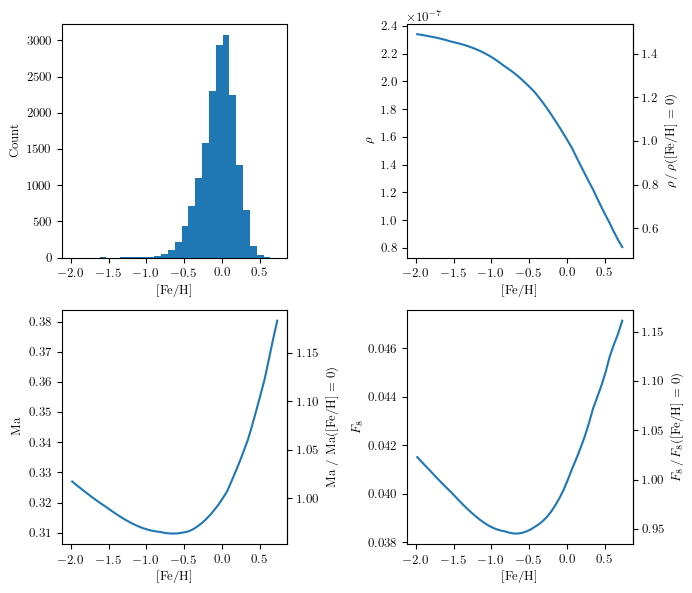

In [11]:
FeH_range = np.linspace(cat['FeH'].min(), cat['FeH'].max())
Z_range = base.FeH_to_Z(FeH_range)
i_ref = np.argmin(np.abs(FeH_range))
rho = base.find_rho(base.T_sun, Z_range, base.logg_sun)
Ma = base.calc_Ma(base.logg_sun, base.T_sun, Z_range)
F8 = base.calc_F8(base.logg_sun, base.T_sun, base.M_sun, Z_range)

plt.figure(figsize=(7,6))
plt.subplot(221)
plt.hist(cat['FeH'], bins=30)
plt.xlabel("[Fe/H]")
plt.ylabel("Count")

plt.subplot(222)
plt.plot(base.Z_to_FeH(Z_range), rho)
plt.xlabel("[Fe/H]")
plt.ylabel(r"$\rho$")
secax = plt.gca().secondary_yaxis(
    'right', functions=(lambda x: x / rho[i_ref], lambda x: x * rho[i_ref]))
secax.set_ylabel(r"$\rho \, / \, \rho$([Fe/H] = 0)")

plt.subplot(223)
plt.plot(base.Z_to_FeH(Z_range), Ma)
plt.xlabel("[Fe/H]")
plt.ylabel("Ma")
secax = plt.gca().secondary_yaxis(
    'right', functions=(lambda x: x / Ma[i_ref], lambda x: x * Ma[i_ref]))
secax.set_ylabel("Ma / Ma([Fe/H] = 0)")

plt.subplot(224)
plt.plot(base.Z_to_FeH(Z_range), F8)
plt.xlabel("[Fe/H]")
plt.ylabel("$F_8$")
secax = plt.gca().secondary_yaxis(
    'right', functions=(lambda x: x / F8[i_ref], lambda x: x * F8[i_ref]))
secax.set_ylabel("$F_8 \, / \, F_8$([Fe/H] = 0)")

plt.tight_layout()

Over the range of [Fe/H] values in our catalog (approximately $-1 < [Fe/H] < 0.5$) and for otherwise solar parameters, increasing metallicity causes a decrease in $\rho$ by a factor of approximately 3 over the full range of metallicity values.
The Mach number, however, has a minimum near $[Fe/H]=-0.75$, with an increase of approximately 22% up to $[Fe/H]=0.5$ but a much slower increase toward lower metallicity.
The corresponding effect on $F_8$ is very comparable to that in Ma.

# Fitting $\Theta$-$M_a$

This is Section 3.3 of the paper

In [12]:
Ma = base.calc_Ma(cat['loggH'], cat['TeffH'], Z)
bp_corr = base.calc_bandpass_correction(cat['TeffH'], cat['loggH'])
empirical_theta = base.calc_theta_from_F8(cat['F8'] / bp_corr, cat['loggH'],
                                             cat['TeffH'], cat['MH'], Z)

This file contains data from three published grids of simulations, with that data stored in this file in a uniform format:

In [13]:
mtd_T, mtd_logg, mtd_FeH, mtd_Ma, mtd_theta, mtd_src = np.genfromtxt("orig_data/ma_theta_data.txt", skip_header=10, unpack=True)
mtd_src = np.array(mtd_src, dtype=int)

# Convert the Tremblay Ma's to vertical-component Ma's
mtd_Ma[mtd_src==2] = mtd_Ma[mtd_src==2] / np.sqrt(3)

Coverage (red dots) in T-logg space, with our Ma values produced for each Kepler star:

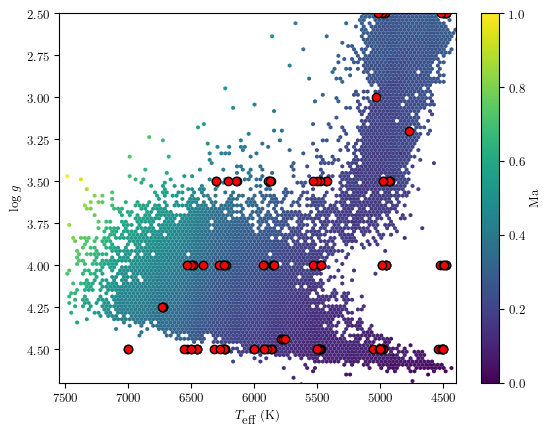

In [14]:
plt.hexbin(
    cat['TeffH'][cat['loggH']>2.5],
    cat['loggH'][cat['loggH']>2.5],
    Ma[cat['loggH']>2.5],
    edgecolor=None
    )
plt.scatter(mtd_T, mtd_logg, color='r', edgecolor='k')
plt.colorbar().set_label("Ma")
plt.xlim(7550, 4400)
plt.ylim(4.7, 2.5)
plt.xlabel(r"$T_\textrm{eff}$ (K)")
plt.ylabel("log $g$");

It can be seen that the highest Ma values produced by our Kepler stars aren't covered by these simulations.

## Fitting the data

### Fitting the center

In [15]:
def fitted_Ma_fcn(x, A, B, e2, C):
    return 1 / (A * x ** (-2*C) + B * x ** e2) ** (1/C)

<ipython-input-15-96b4076bc14e>:2: RuntimeWarning: invalid value encountered in power
  return 1 / (A * x ** (-2*C) + B * x ** e2) ** (1/C)


fit: theta = 1 / (20.98 * Ma ^ -2*5.29 + 3.537e+06 * Ma ^ -0.8416) ^ 1/5.29
RMSE: 0.008180281901564265


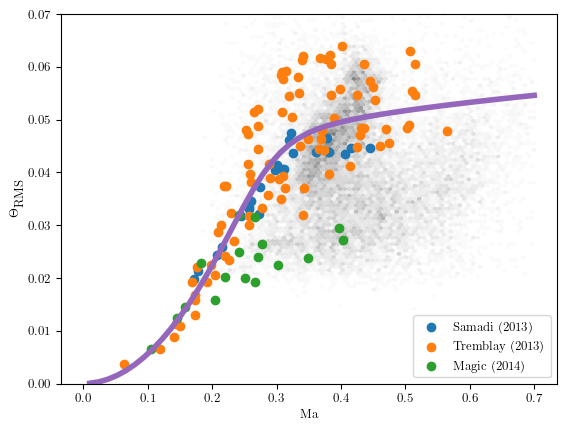

In [16]:
plt.hexbin(
    Ma[cat['loggH']>2.5],
    empirical_theta[cat['loggH']>2.5],
    extent=(0, 0.7, 0, .07),
    cmap="gray_r",
    alpha=0.5,
    edgecolor=None
    )
# 
# plt.colorbar().set_label("Number of Kepler stars")

plt.scatter(mtd_Ma[mtd_src==1], mtd_theta[mtd_src==1], c="C0", label="Samadi (2013)")
plt.scatter(mtd_Ma[mtd_src==2], mtd_theta[mtd_src==2], c="C1", label="Tremblay (2013)")
plt.scatter(mtd_Ma[mtd_src==3], mtd_theta[mtd_src==3], c="C2", label="Magic (2014)")

popt_central, pcov = scipy.optimize.curve_fit(
    fitted_Ma_fcn, mtd_Ma, mtd_theta,
    p0=(1, 1, 1, 1), maxfev=10000000)

A, B, e2, C,= popt_central
print(f"fit: theta = 1 / ({A:.4g} * Ma ^ -2*{C:.2f} + {B:.4g} * Ma ^ {e2:.4g}) ^ 1/{C:.2f}")
rmse = np.sqrt(np.mean(np.square(mtd_theta - fitted_Ma_fcn(mtd_Ma, *popt_central))))
print(f"RMSE: {rmse}")
x = np.linspace(0.01, .7)
plt.plot(x, fitted_Ma_fcn(x, *popt_central), "C4", linewidth=4)


plt.legend(loc="lower right")
plt.ylim(0, .07)
plt.xlabel("Ma")
plt.ylabel(r"$\Theta_\textrm{RMS}$");

The above fit is copied into `base.calc_theta`

log g fit slope: 0.0031, r: 0.34, p: 7.2e-05
[Fe/H] fit slope: -0.0033, r: -0.47, p: 3e-08
T fit slope: 3.1e-06, r: 0.31, p: 0.00037


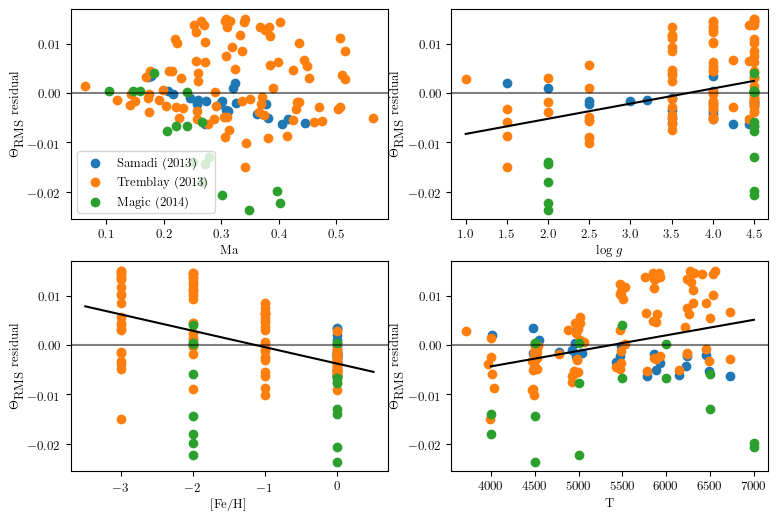

In [17]:
plt.figure(figsize=(9,6))

plt.subplot(221)
plt.scatter(mtd_Ma[mtd_src==1], mtd_theta[mtd_src==1] - fitted_Ma_fcn(mtd_Ma[mtd_src==1], *popt_central),
            c="C0", label="Samadi (2013)")
plt.scatter(mtd_Ma[mtd_src==2], mtd_theta[mtd_src==2] - fitted_Ma_fcn(mtd_Ma[mtd_src==2], *popt_central),
            c="C1", label="Tremblay (2013)")
plt.scatter(mtd_Ma[mtd_src==3], mtd_theta[mtd_src==3] - fitted_Ma_fcn(mtd_Ma[mtd_src==3], *popt_central),
            c="C2", label="Magic (2014)")
plt.legend()
plt.axhline(0, alpha=0.5, color='k')
plt.xlabel("Ma")
plt.ylabel(r"$\Theta_\textrm{RMS}$ residual")

plt.subplot(222)
plt.scatter(mtd_logg[mtd_src==1], mtd_theta[mtd_src==1] - fitted_Ma_fcn(mtd_Ma[mtd_src==1], *popt_central),
            c="C0", label="Samadi (2013)")
plt.scatter(mtd_logg[mtd_src==2], mtd_theta[mtd_src==2] - fitted_Ma_fcn(mtd_Ma[mtd_src==2], *popt_central),
            c="C1", label="Tremblay (2013)")
plt.scatter(mtd_logg[mtd_src==3], mtd_theta[mtd_src==3] - fitted_Ma_fcn(mtd_Ma[mtd_src==3], *popt_central),
            c="C2", label="Magic (2014)")

res = scipy.stats.linregress(mtd_logg, mtd_theta - fitted_Ma_fcn(mtd_Ma, *popt_central))

x = np.linspace(1, 4.5)
plt.plot(x, res.slope * x + res.intercept, c="k")

print(f"log g fit slope: {res.slope:.2g}, r: {res.rvalue:.2f}, p: {res.pvalue:.2g}")
plt.axhline(0, alpha=0.5, color='k')
plt.xlabel("log $g$")
plt.ylabel(r"$\Theta_\textrm{RMS}$ residual")

plt.subplot(223)
plt.scatter(mtd_FeH[mtd_src==1], mtd_theta[mtd_src==1] - fitted_Ma_fcn(mtd_Ma[mtd_src==1], *popt_central),
            c="C0", label="Samadi (2013)")
plt.scatter(mtd_FeH[mtd_src==2], mtd_theta[mtd_src==2] - fitted_Ma_fcn(mtd_Ma[mtd_src==2], *popt_central),
            c="C1", label="Tremblay (2013)")
plt.scatter(mtd_FeH[mtd_src==3], mtd_theta[mtd_src==3] - fitted_Ma_fcn(mtd_Ma[mtd_src==3], *popt_central),
            c="C2", label="Magic (2014)")

res = scipy.stats.linregress(mtd_FeH, mtd_theta - fitted_Ma_fcn(mtd_Ma, *popt_central))

x = np.linspace(-3.5, 0.5)
plt.plot(x, res.slope * x + res.intercept, c="k")

print(f"[Fe/H] fit slope: {res.slope:.2g}, r: {res.rvalue:.2f}, p: {res.pvalue:.2g}")
plt.axhline(0, alpha=0.5, color='k')
plt.xlabel("[Fe/H]")
plt.ylabel(r"$\Theta_\textrm{RMS}$ residual")

plt.subplot(224)
plt.scatter(mtd_T[mtd_src==1], mtd_theta[mtd_src==1] - fitted_Ma_fcn(mtd_Ma[mtd_src==1], *popt_central),
            c="C0", label="Samadi (2013)")
plt.scatter(mtd_T[mtd_src==2], mtd_theta[mtd_src==2] - fitted_Ma_fcn(mtd_Ma[mtd_src==2], *popt_central),
            c="C1", label="Tremblay (2013)")
plt.scatter(mtd_T[mtd_src==3], mtd_theta[mtd_src==3] - fitted_Ma_fcn(mtd_Ma[mtd_src==3], *popt_central),
            c="C2", label="Magic (2014)")

res = scipy.stats.linregress(mtd_T, mtd_theta - fitted_Ma_fcn(mtd_Ma, *popt_central))

x = np.linspace(4000, 7000)
plt.plot(x, res.slope * x + res.intercept, c="k")

print(f"T fit slope: {res.slope:.2g}, r: {res.rvalue:.2f}, p: {res.pvalue:.2g}")
plt.axhline(0, alpha=0.5, color='k')
plt.xlabel("T")
plt.ylabel(r"$\Theta_\textrm{RMS}$ residual");

The residuals of this fit have some trends, but nothing very strong.

### Fitting the upper bound

To determine the "upper bound", two different, manually-chosen lines are drawn (shown below in red). A point is considered part of the upper bound if it falls above any one of those three lines.

In [18]:
def scale_only_envelope_fcn(x, yscale):
    return yscale * fitted_Ma_fcn(x, *popt_central)

fit: theta = 1.27 * f(Ma)


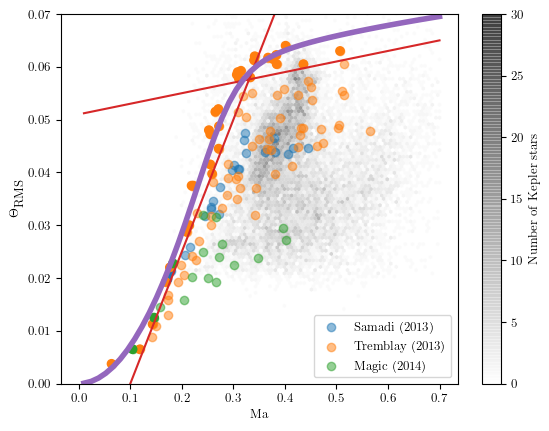

In [19]:
plt.hexbin(
    Ma[cat['loggH']>2.5],
    empirical_theta[cat['loggH']>2.5],
    extent=(0, 0.7, 0, .07),
    cmap="gray_r",
    alpha=0.5,
    edgecolor=None
    )

plt.colorbar().set_label("Number of Kepler stars")

plt.scatter(mtd_Ma[mtd_src==1], mtd_theta[mtd_src==1], c="C0", label="Samadi (2013)", alpha=0.5)
plt.scatter(mtd_Ma[mtd_src==2], mtd_theta[mtd_src==2], c="C1", label="Tremblay (2013)", alpha=0.5)
plt.scatter(mtd_Ma[mtd_src==3], mtd_theta[mtd_src==3], c="C2", label="Magic (2014)", alpha=0.5)

selected = np.zeros_like(mtd_Ma, dtype=bool)

x = np.linspace(0.01, 0.7)
lines = [lambda x: 0.25 * (x - 0.1), lambda x: .02*x + 0.051]

for line in lines:
    plt.plot(x, line(x), "C3")
    selected[mtd_theta > (line(mtd_Ma))] = 1

plt.scatter(mtd_Ma[selected], mtd_theta[selected], color=["C" + str(s-1) for s in mtd_src[selected]])

popt_upper_scaley, pcov = scipy.optimize.curve_fit(
    scale_only_envelope_fcn, mtd_Ma[selected], mtd_theta[selected],
    p0=(1,))

yscale, = popt_upper_scaley
print(f"fit: theta = {yscale:.2f} * f(Ma)")
plt.plot(x, scale_only_envelope_fcn(x, *popt_upper_scaley), "C4", linewidth=4)

plt.legend(loc="lower right")
plt.ylim(0, .07)
plt.xlabel("Ma")
plt.ylabel(r"$\Theta_\textrm{RMS}$");

The above fit is copied into `base.calc_theta_max`

### Fitting the lower bound

Likewise, a few lines are drawn to define the lower boundry of the cloud. However, here, (owing to the point cloud's concavity on the bottom), a point must lie under all lines to be considered part of the bound.

Below are two possible definitions of the lower bound, and the bottom is our final choice.

fit: theta = 0.82 * f(Ma)


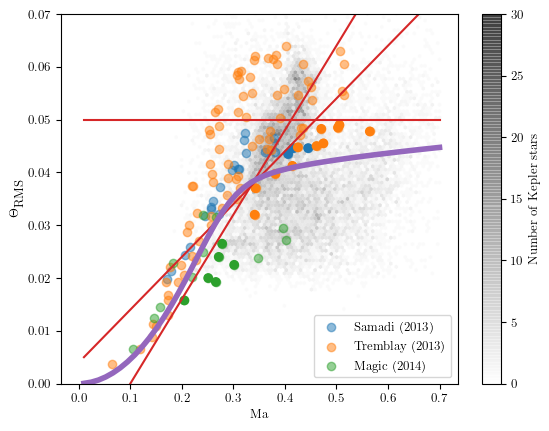

In [20]:
plt.hexbin(
    Ma[cat['loggH']>2.5],
    empirical_theta[cat['loggH']>2.5],
    extent=(0, 0.7, 0, .07),
    cmap="gray_r",
    alpha=0.5,
    edgecolor=None
    )

plt.colorbar().set_label("Number of Kepler stars")

plt.scatter(mtd_Ma[mtd_src==1], mtd_theta[mtd_src==1], c="C0", label="Samadi (2013)", alpha=0.5)
plt.scatter(mtd_Ma[mtd_src==2], mtd_theta[mtd_src==2], c="C1", label="Tremblay (2013)", alpha=0.5)
plt.scatter(mtd_Ma[mtd_src==3], mtd_theta[mtd_src==3], c="C2", label="Magic (2014)", alpha=0.5)

# Block out a few Magic+ points that seem a bit like outliers
selected = (mtd_src != 3) + (mtd_Ma < 0.34)

selected[mtd_theta > 0.55] = 0

x = np.linspace(0.01, 0.7)
lines = [lambda x: 0.16 * (x - 0.1), lambda x: 0*x + 0.05, lambda x: 0.1 * x + .004]

for line in lines:
    plt.plot(x, line(x), "C3")
    selected *= mtd_theta < (line(mtd_Ma))

plt.scatter(mtd_Ma[selected], mtd_theta[selected], color=["C" + str(s-1) for s in mtd_src[selected]])

popt_lower_scaley, pcov = scipy.optimize.curve_fit(
    scale_only_envelope_fcn, mtd_Ma[selected], mtd_theta[selected],
    p0=(1,))

yscale, = popt_lower_scaley
print(f"fit: theta = {yscale:.2g} * f(Ma)")
plt.plot(x, scale_only_envelope_fcn(x, *popt_lower_scaley), "C4", linewidth=4)

plt.legend(loc="lower right")
plt.ylim(0, .07)
plt.xlabel("Ma")
plt.ylabel(r"$\Theta_\textrm{RMS}$");

fit: theta = 0.62 * f(Ma)


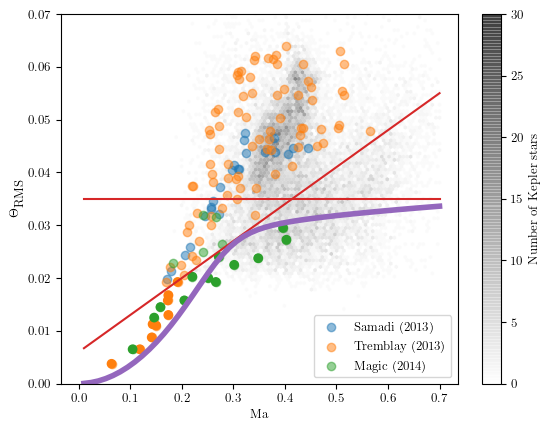

In [21]:
plt.hexbin(
    Ma[cat['loggH']>2.5],
    empirical_theta[cat['loggH']>2.5],
    extent=(0, 0.7, 0, .07),
    cmap="gray_r",
    alpha=0.5,
    edgecolor=None
    )

plt.colorbar().set_label("Number of Kepler stars")

plt.scatter(mtd_Ma[mtd_src==1], mtd_theta[mtd_src==1], c="C0", label="Samadi (2013)", alpha=0.5)
plt.scatter(mtd_Ma[mtd_src==2], mtd_theta[mtd_src==2], c="C1", label="Tremblay (2013)", alpha=0.5)
plt.scatter(mtd_Ma[mtd_src==3], mtd_theta[mtd_src==3], c="C2", label="Magic (2014)", alpha=0.5)

selected = np.ones_like(mtd_Ma, dtype=bool)

selected[mtd_theta > 0.55] = 0

x = np.linspace(0.01, 0.7)
lines = [lambda x: 0*x + 0.035, lambda x: 0.07 * x + .006]

for line in lines:
    plt.plot(x, line(x), "C3")
    selected *= mtd_theta < (line(mtd_Ma))

plt.scatter(mtd_Ma[selected], mtd_theta[selected], color=["C" + str(s-1) for s in mtd_src[selected]])

popt_lower_scaley, pcov = scipy.optimize.curve_fit(scale_only_envelope_fcn, mtd_Ma[selected], mtd_theta[selected],
                                            p0=(1,),
                                           )

yscale, = popt_lower_scaley
print(f"fit: theta = {yscale:.2g} * f(Ma)")
plt.plot(x, scale_only_envelope_fcn(x, *popt_lower_scaley), "C4", linewidth=4)

plt.legend(loc="lower right")
plt.ylim(0, .07)
plt.xlabel("Ma")
plt.ylabel(r"$\Theta_\textrm{RMS}$");

The above fit is copied into `base.calc_theta_min`

## All fitted curves plotted together: Paper Figure 2

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


central: theta = 1 / (20.98 * Ma ^ -2*5.29 + 3.5e+06 * Ma ^ -0.84) ^ 1/5.29
upper: theta = 1.27 * central_fit(Ma)
lower: theta = 0.62 * central_fit(Ma)


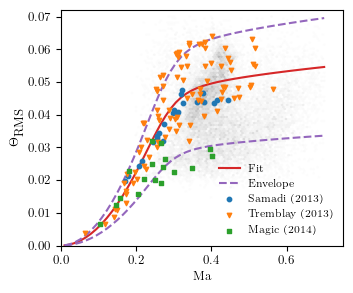

In [22]:
plt.figure(figsize=(FIG_WIDTH, 3))

plt.hexbin(
    Ma[cat['loggH']>2.5],
    empirical_theta[cat['loggH']>2.5],
    extent=(0, 0.7, 0, .07),
    cmap="gray_r",
    alpha=0.3, edgecolors=None
    )

#plt.colorbar().set_label("Number of Kepler stars")

plt.scatter(mtd_Ma[mtd_src==1], mtd_theta[mtd_src==1], c="C0", marker='o', label="Samadi (2013)", s=10, zorder=10)
plt.scatter(mtd_Ma[mtd_src==2], mtd_theta[mtd_src==2], c="C1", marker='v', label="Tremblay (2013)", s=10, zorder=10)
plt.scatter(mtd_Ma[mtd_src==3], mtd_theta[mtd_src==3], c="C2", marker='s', label="Magic (2014)", s=10, zorder=10)

x = np.linspace(0.01, 0.7)
plt.plot(x, fitted_Ma_fcn(x, *popt_central), c="C3", label="Fit", linewidth=1.5)
plt.plot(x, scale_only_envelope_fcn(x, *popt_upper_scaley), "--C4", label="Envelope", linewidth=1.5)
plt.plot(x, scale_only_envelope_fcn(x, *popt_lower_scaley), "--C4", linewidth=1.5)

A, B, e2, C,= popt_central
print(f"central: theta = 1 / ({A:.2f} * Ma ^ -2*{C:.2f} + {B:.2g} * Ma ^ {e2:.2f}) ^ 1/{C:.2f}")

yscale, = popt_upper_scaley
print(f"upper: theta = {yscale:.2f} * central_fit(Ma)")
yscale, = popt_lower_scaley
print(f"lower: theta = {yscale:.2f} * central_fit(Ma)")

plt.legend(loc="lower right", fontsize='small', frameon=False)
plt.xlim(0, .75)
plt.ylim(0, 0.072)
plt.xlabel("Ma")
plt.ylabel(r"$\Theta_\textrm{RMS}$")
plt.tight_layout()
if save_plots:
    plt.savefig("paper/figures/ma-theta.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()

In [23]:
solar_theta = base.calc_theta(base.calc_Ma(base.logg_sun, base.T_sun, base.Z_sun))
print(f"Modeled solar Theta: {solar_theta:.3g}")

Modeled solar Theta: 0.0455


# Kepler bandpass correction: Paper Figure 12

Here we simply plot the pre-computed bandpass correction factors.

In [24]:
kbc_Teff, kbc_logg, kbc_sig_mult = np.genfromtxt("orig_data/bandpass_adjustment.txt", skip_header=4, unpack=True)

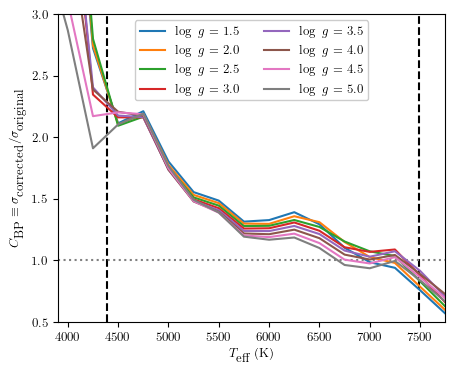

In [25]:
plt.figure(figsize=(5, 4))

plt.axvline(cat['TeffH'].min(), linestyle='--', color='black')
plt.axvline(cat['TeffH'].max(), linestyle='--', color='black')
plt.axhline(1, linestyle=':', color='gray')

kbc_logg_vals = np.unique(kbc_logg)
for kbc_logg_val in kbc_logg_vals:
    plt.plot(kbc_Teff[kbc_logg == kbc_logg_val],
             kbc_sig_mult[kbc_logg == kbc_logg_val],
             label=f"$\log\ g$ = {kbc_logg_val:.1f}")
    
plt.legend(ncol=2, framealpha=1)

plt.xlabel(r"$T_\textrm{eff}$ (K)")
plt.ylabel(r"$C_\textrm{BP} \equiv \sigma_\textrm{corrected} / \sigma_\textrm{original}$")

plt.ylim(0.5, 3)
plt.xlim(3900, 7750)

if save_plots:
    plt.savefig("paper/figures/kep-bandpass.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

# Comparing models for $\Lambda$

In [26]:
T_T, T_logg, T_A = np.genfromtxt("orig_data/Trampedach2013.txt", skip_header=5, skip_footer=9,
                                 usecols=(2, 5, 9), unpack=True)

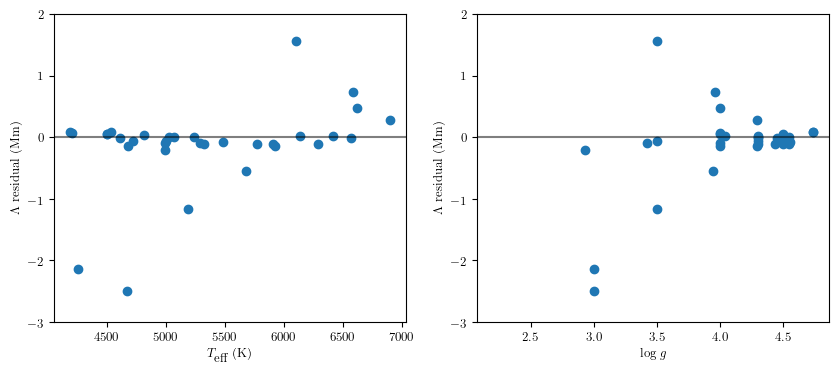

In [27]:
Lambda_pred = base.Lambda(T_T, T_logg) * 1e-8
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.scatter(T_T, T_A - Lambda_pred)
# A few outliers clipped
plt.ylim(-3, 2)
plt.xlabel(r"$T_\textrm{eff}$ (K)")
plt.ylabel("$\Lambda$ residual (Mm)")
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(122)
plt.scatter(T_logg, T_A - Lambda_pred)
plt.ylim(-3, 2)
plt.xlabel("log $g$")
plt.ylabel("$\Lambda$ residual (Mm)")
plt.axhline(0, c='k', alpha=0.5);

The Trampedach+2013 fit for granule sizes generally matches the individual simulations quite well.

Following is the analysis mentioned in the paper regarding the trend in "best-fit $\beta$ values"

In [28]:
# Dividing the data in coarse bins
F8_obs_mean, logg_mean, T_mean, binn = scipy.stats.binned_statistic_2d(
    cat['loggH'], cat['TeffH'], cat['F8'], 'mean', 30,
    range=[[2.5, cat['loggH'].max()], [cat['TeffH'].min(), cat['TeffH'].max()]])
M_mean, logg_mean, T_mean, binn = scipy.stats.binned_statistic_2d(
    cat['loggH'], cat['TeffH'], cat['MH'], 'mean', 30,
    range=[[2.5, cat['loggH'].max()], [cat['TeffH'].min(), cat['TeffH'].max()]])
Z_mean, logg_mean, T_mean, binn = scipy.stats.binned_statistic_2d(
    cat['loggH'], cat['TeffH'], Z, 'mean', 30,
    range=[[2.5, cat['loggH'].max()], [cat['TeffH'].min(), cat['TeffH'].max()]])
count, logg_mean, T_mean, binn = scipy.stats.binned_statistic_2d(
    cat['loggH'], cat['TeffH'], Z, 'count', 30,
    range=[[2.5, cat['loggH'].max()], [cat['TeffH'].min(), cat['TeffH'].max()]])

In [29]:
# Hack to temporarily use the beta-based Lambda in all functions
orig_lambda = base.Lambda
base.Lambda = base.Lambda_beta

# Compute a best-fit beta for each bin
best_beta = np.empty_like(F8_obs_mean)
best_beta.fill(np.nan)
for i in range(F8_obs_mean.shape[0]):
    logg_val = logg_mean[i]
    for j in range(F8_obs_mean.shape[1]):
        F8_val = F8_obs_mean[i, j]
        if np.isnan(F8_val):
            continue
        T_val = T_mean[j]
        M_val = M_mean[i, j]
        Z_val = Z_mean[i, j]
        bp_cor = base.calc_bandpass_correction(T_val, logg_val)
        res = scipy.optimize.minimize(lambda beta: np.abs(F8_val - bp_cor * base.calc_F8(logg_val, T_val, M_val, Z_val, beta=beta, bp_cor=False)),
                                      [10],
                                      bounds=((1, 20),))
        best_beta[i, j] = res.x

# Return to the final Lambda function
base.Lambda = orig_lambda

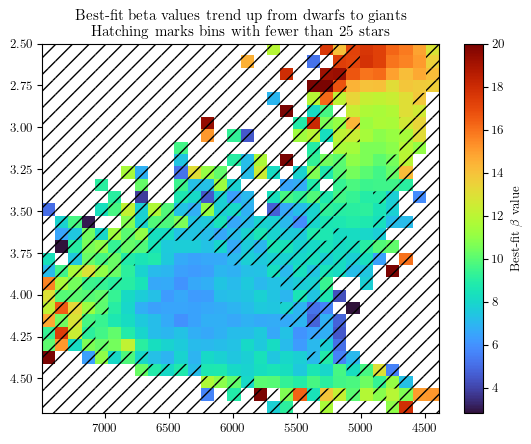

In [30]:
im = plt.imshow(best_beta,
                extent=(T_mean.min(), T_mean.max(), logg_mean.max(), logg_mean.min()),
                aspect='auto',
                cmap='turbo',
                interpolation='none')
plt.colorbar().set_label(r"Best-fit $\beta$ value");
plt.pcolor(T_mean, logg_mean, np.ma.masked_greater(count, 25), hatch='//', alpha=0)
plt.xlim(*reversed(plt.xlim()))
plt.title("Best-fit beta values trend up from dwarfs to giants\nHatching marks bins with fewer than 25 stars");

This trend resembles that noted in Trampedach+ (2013)

# $F_8$ Data & Models

In [31]:
F8_observed = base.F8_from_logg(cat['F8logg'])

F8_modeled_orig = base.calc_F8_old(cat['loggH'], cat['TeffH'], cat["MH"])

# Calculating Ma is slow, so we pre-calculate it before all this F8 work
Ma = base.calc_Ma(cat['loggH'], cat['TeffH'], Z)

F8_modeled_no_bp_cor = base.calc_F8(cat['loggH'], cat['TeffH'], cat["MH"], Z, Ma=Ma, bp_cor=False)

F8_ratio_env_no_bp_cor = base.calc_F8_ratio_to_envelope(
    cat['F8'], cat['loggH'], cat['TeffH'], cat['MH'], Z,
    F8_fcn=lambda *args: base.calc_F8(*args, bp_cor=False), Ma=Ma)

# This factor converts bolometric flicker to Kepler flicker
bp_correction = base.calc_bandpass_correction(cat['TeffH'], cat['loggH'])

F8_modeled = F8_modeled_no_bp_cor * bp_correction
F8_ratio_env = base.calc_F8_ratio_to_envelope(
    cat['F8'], cat['loggH'], cat['TeffH'], cat['MH'], Z,
    F8_fcn=base.calc_F8, Ma=Ma)

In [32]:
# Prepare a main-sequence slice, used in two sub-sections below

mstype, msT, mslogg = [], np.array([]), np.array([])
for line in open("orig_data/EEM_dwarf_UBVIJHK_colors_Teff.txt").readlines():
    if line.startswith('#'):
        if len(mstype):
            # Stop at the end of the data table
            break
        continue
    data = line.split()
    if data[29].startswith('...'):
        continue
    mstype.append(data[0])
    msT_val = int(data[1])
    if 0.9*cat['TeffH'].min() < msT_val < 1.1*cat['TeffH'].max():
        msT = np.append(msT, msT_val)
        R = float(data[28])
        M = float(data[29])
        mslogg = np.append(mslogg, np.log10(base.G * M * base.M_sun_grams / (R * base.R_sun_cm)**2))

## The Data: Paper Figure 1

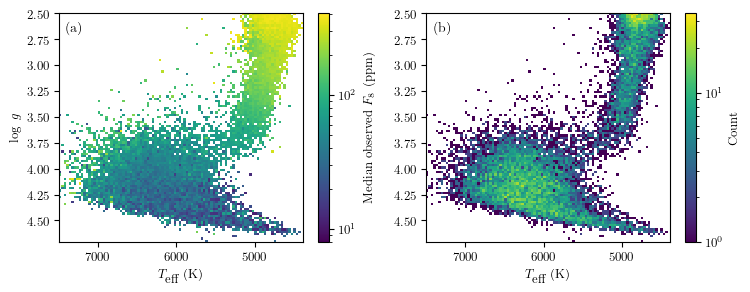

In [33]:
plt.figure(figsize=(WIDE_FIG_WIDTH, 3))

plt.subplot(121)
base.plot_quasi_hr(cat, F8_observed * 1000, "Median observed $F_8$ (ppm)",
                   fill_in_bg=False, log_norm=True, vmin=8)
plt.text(.03, .92, "(a)", fontsize=10, transform=plt.gca().transAxes)

plt.subplot(122)
base.plot_quasi_hr(cat, F8_observed, "Count", stat='count', log_norm=True,
                   fill_in_bg=False, show_y_label=False)
plt.text(.03, .92, "(b)", fontsize=10, transform=plt.gca().transAxes)

plt.tight_layout()
if save_plots:
    plt.savefig("paper/figures/showing-flicker-data.pdf", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

## Observed/Modeled Ratio

### Initial ratio

This is the ratio with the original model of Cranmer+2014 (without the empirical $S$ factor)

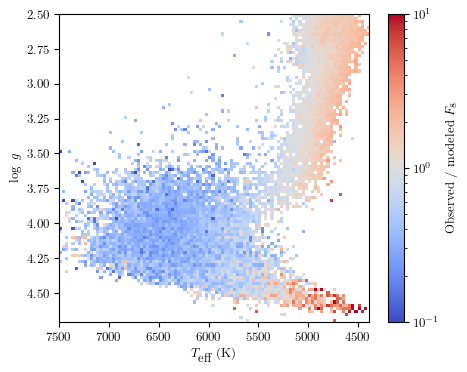

In [34]:
plt.figure(figsize=(5, 4))

base.plot_quasi_hr(cat, F8_observed / F8_modeled_orig, "Observed / modeled $F_8$", cmap='coolwarm',
                   vmin=1e-1, vmax=1e1, log_norm=True,
                   fill_in_bg=False);

### Ratio w/ All Updates

This includes:

* An Ma expression derived from $\sigma T^4 = C \rho v^3$, with $C$ fitted to the Tremblay+2013 simulation grid
* An updated $\Theta$(Ma) relation based on the Magic, Tremblay and Samadi simulation grids
 * Including both the central fit and the envelope form
* Granule sizes based on Trampedach+2013
* An expression for $\sigma$ that maintains equality throughout, rather than a scaling relation relative to the solar value

But not the bandpass correction term (see next plot)

On the left is the central-fit model, and on the right is the envelope model

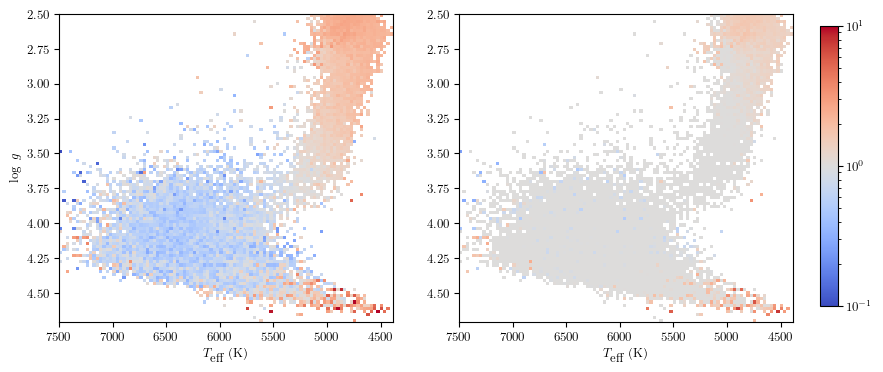

In [35]:
fig = plt.figure(figsize=(9, 4))

plt.subplot(121)
base.plot_quasi_hr(cat, F8_observed / F8_modeled_no_bp_cor, "Observed / modeled $F_8$", cmap='coolwarm',
                   vmin=1e-1, vmax=1e1, log_norm=True,
                   fill_in_bg=False, show_colorbar=False)

plt.subplot(122)
im = base.plot_quasi_hr(cat, F8_ratio_env_no_bp_cor, "Observed / modeled $F_8$", cmap='coolwarm',
                       vmin=1e-1, vmax=1e1, log_norm=True, show_y_label=False,
                       fill_in_bg=False, show_colorbar=False)
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.97, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax);

And here we add in the bandpass correction term

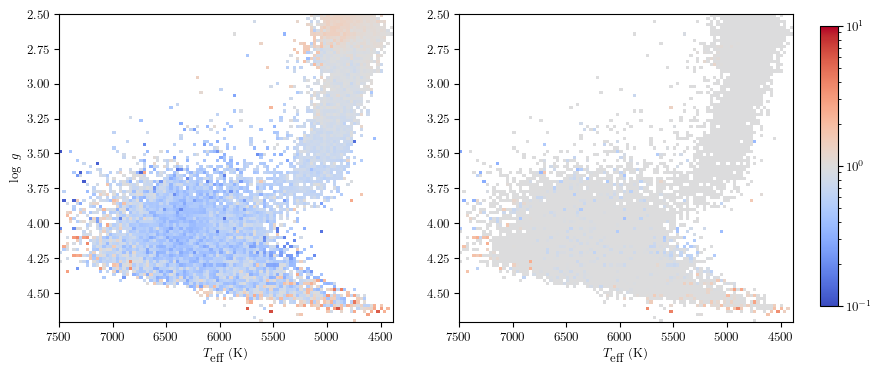

In [36]:
fig = plt.figure(figsize=(9, 4))

plt.subplot(121)
base.plot_quasi_hr(cat, F8_observed / F8_modeled, "Observed / modeled $F_8$", cmap='coolwarm',
                   vmin=1e-1, vmax=1e1, log_norm=True,
                   fill_in_bg=False, show_colorbar=False)

plt.subplot(122)
im = base.plot_quasi_hr(cat, F8_ratio_env, "Observed / modeled $F_8$", cmap='coolwarm',
                        vmin=1e-1, vmax=1e1, log_norm=True, show_y_label=False,
                        fill_in_bg=False, show_colorbar=False)
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.97, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax);

### Before & After: Paper Figure 5

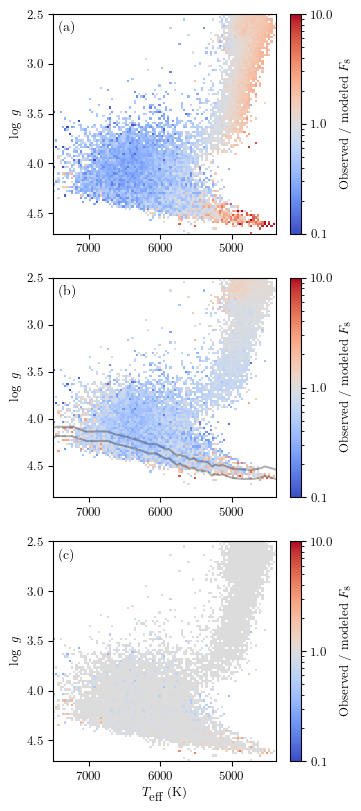

In [37]:
plt.figure(figsize=(FIG_WIDTH, 9.7))

plt.subplot(311)

base.plot_quasi_hr(cat, F8_observed / F8_modeled_orig, "Observed / modeled $F_8$", cmap='coolwarm',
                   vmin=1e-1, vmax=1e1, log_norm=True,
                   fill_in_bg=False, show_x_label=False,
                   cbar_kwargs={'format': matplotlib.ticker.ScalarFormatter()})
plt.text(.03, .92, "(a)", fontsize=10, transform=plt.gca().transAxes)

plt.subplot(312)
base.plot_quasi_hr(cat, F8_observed / F8_modeled, "Observed / modeled $F_8$", cmap='coolwarm',
                   vmin=1e-1, vmax=1e1, log_norm=True,
                   fill_in_bg=False, show_x_label=False,
                   cbar_kwargs={'format': matplotlib.ticker.ScalarFormatter()})
plt.text(.03, .92, "(b)", fontsize=10, transform=plt.gca().transAxes)
# plt.fill_between(msT, mslogg + .05, mslogg - .05, alpha=0.5, color="C2")
plt.plot(msT, mslogg + 0.05, alpha=0.3, color='k')
plt.plot(msT, mslogg - 0.05, alpha=0.3, color='k')

plt.subplot(313)
base.plot_quasi_hr(cat, F8_ratio_env, "Observed / modeled $F_8$", cmap='coolwarm',
                   vmin=1e-1, vmax=1e1, log_norm=True,
                   fill_in_bg=False, cbar_kwargs={'format': matplotlib.ticker.ScalarFormatter()})
plt.text(.03, .92, "(c)", fontsize=10, transform=plt.gca().transAxes)

#plt.tight_layout()
if save_plots:
    plt.savefig("paper/figures/before-and-after.pdf", bbox_inches='tight', pad_inches=0, dpi=400)
plt.show()

In [38]:
print(f"{np.sum(F8_ratio_env==1) / F8_ratio_env.size*100:.2f}% of stars have an envelope ratio of 1")

78.03% of stars have an envelope ratio of 1


### Computing and minimzing the $\Delta$ statistic

In [39]:
print("10 ^ RMS[log(ratio)] with the before-model is {:.3f}".format(
      10**np.sqrt(np.mean(np.square(np.log10(F8_observed / F8_modeled_orig))))))

print("10 ^ RMS[log(ratio)] with our model        is {:.3f}".format(
      10**np.sqrt(np.mean(np.square(np.log10(F8_observed / F8_modeled))))))

10 ^ RMS[log(ratio)] with the before-model is 2.495
10 ^ RMS[log(ratio)] with our model        is 2.016


In [40]:
res = scipy.optimize.minimize(
    lambda factor: 10**np.sqrt(np.mean(np.square(np.log10(F8_observed / factor / F8_modeled)))),
    [1],
    bounds=[(.1, 2)]
)
print(f"Minimal RMS[log(ratio)] with our model is {res.fun:.3f}")
print(f"with F8_mod -> {res.x[0]:.3f} * F8_mod")

Minimal RMS[log(ratio)] with our model is 1.752
with F8_mod -> 0.657 * F8_mod


## Mini-distributions:  Paper Figure 7

In [41]:
# Grab the fixed ratios defining the envelope
# F8 \propto sigma \propto Theta^2
envelope_low = (base.calc_theta_min(0.5) / base.calc_theta(0.5))**2
envelope_high = (base.calc_theta_max(0.5) / base.calc_theta(0.5))**2

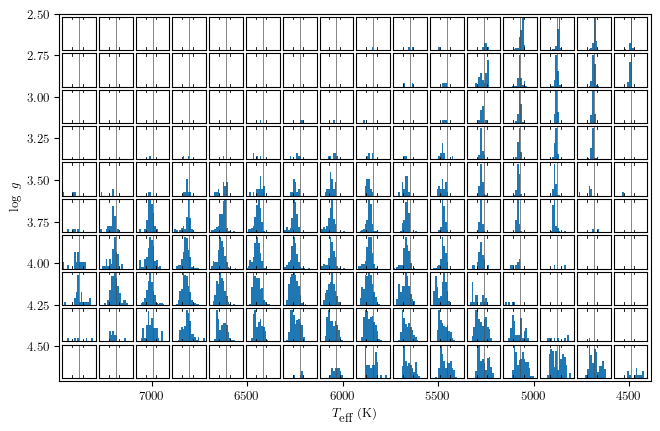

In [42]:
grid_size_x = 16
grid_size_y = 10

T_vals = np.linspace(cat['TeffH'].max(), cat['TeffH'].min(), grid_size_x+1)
logg_vals = np.linspace(cat['loggH'].max(), cat['loggH'].min(), grid_size_y+1)

# This is the outer set of axes
fig, ax = plt.subplots(figsize=(WIDE_FIG_WIDTH, WIDE_FIG_WIDTH * 10/16))
ax.set_xlim(cat['TeffH'].max(), cat['TeffH'].min())
ax.set_ylim(cat['loggH'].max(), 2.5)
ax.set_xlabel(r"$T_\textrm{eff}$ (K)")
ax.set_ylabel("$\log\ g$")

# Figure out where the main axes lie, and work out parameters for
# positioning the mini-plots
xoff, yoff, width, height = ax.get_position().bounds
padx = .002
pady = padx * 16/10
xoff += 2 * padx
yoff += 2 * pady
width -= 2 * padx
height -= 2 * pady
dw = width / grid_size_x
dh = height / grid_size_y

for i, (T_stop, T_start) in enumerate(zip(T_vals[:-1], T_vals[1:])):
    for j, (logg_stop, logg_start) in enumerate(zip(logg_vals[:-1], logg_vals[1:])):
        sel  = cat['loggH'] >= logg_start
        sel *= cat['loggH'] <  logg_stop
        sel *= cat['TeffH'] >= T_start
        sel *= cat['TeffH'] <  T_stop
        
        ax = fig.add_axes([xoff + i*dw, yoff + j*dh, dw - 2*padx, dh - 2*pady])
        n, _, _ = ax.hist(np.log10(cat['F8'][sel] / F8_modeled[sel]),
                          bins=20,
                          range=(-1, 1),
                          histtype='stepfilled')
        
        # Plot the "ratio = 1" line
        ax.axvline(0, color='0.3', alpha=0.8, linewidth=0.6)
        
        # Plot the envelope ticks
        ax.axvline(np.log10(envelope_low), color='k', ymin=0.92, linewidth=.6)
        ax.axvline(np.log10(envelope_low), color='k', ymax=0.08, linewidth=.6)
        ax.axvline(np.log10(envelope_high), color='k', ymin=0.92, linewidth=.6)
        ax.axvline(np.log10(envelope_high), color='k', ymax=0.08, linewidth=.6)
        
        ax.set_xlim(-1, 1)
        if n.max() < 10:
            ax.set_ylim(0, 10)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

if save_plots:
    plt.savefig("paper/figures/mini-dists.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

# Solar Neighborhood

In [43]:
delta_logg = 0.075
delta_T = 150
sel_sn = ((cat['loggH'] < (base.logg_sun+delta_logg))
          * (cat['loggH'] > (base.logg_sun-delta_logg))
          * (cat['Teff'] < (base.T_sun+delta_T))
          * (cat['TeffH'] > (base.T_sun-delta_T)))

cat_sn = cat[sel_sn]

print(f"The neighborhood is {base.T_sun - delta_T} < T < {base.T_sun + delta_T},"
      f" {base.logg_sun - delta_logg:.3f} < logg < {base.logg_sun + delta_logg:.3f}")

The neighborhood is 5620 < T < 5920, 4.363 < logg < 4.513


/home/sam/Documents/Research/Kepler Project/base.py:672: RuntimeWarning: divide by zero encountered in log2
  im = plt.imshow(scale_fcn(stat),


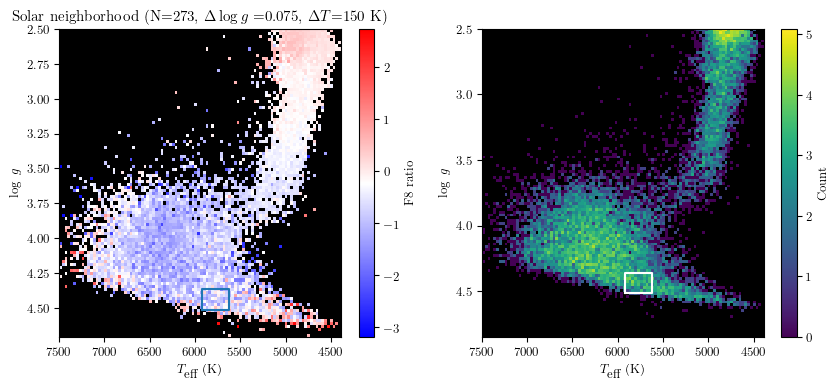

In [44]:
plt.figure(figsize=(10,4))

plt.subplot(121)
base.plot_quasi_hr(cat, cat['F8'] / F8_modeled, r"F8 ratio", 'bwr',
                   scale_fcn=np.log2)
plt.title(f"Solar neighborhood (N={np.sum(sel_sn)}, $\Delta \log g$ ={delta_logg}, $\Delta T$={delta_T} K)")
plt.plot([base.T_sun + delta_T, base.T_sun - delta_T,
          base.T_sun - delta_T, base.T_sun + delta_T, base.T_sun + delta_T],
         [base.logg_sun + delta_logg, base.logg_sun + delta_logg,
          base.logg_sun - delta_logg, base.logg_sun - delta_logg, base.logg_sun + delta_logg])

plt.subplot(122)
base.plot_quasi_hr(cat, cat['F8'] / F8_modeled, r"Count", 'viridis',
                   scale_fcn=np.log2, stat='count')
plt.plot([base.T_sun + delta_T, base.T_sun - delta_T,
          base.T_sun - delta_T, base.T_sun + delta_T, base.T_sun + delta_T],
         [base.logg_sun + delta_logg, base.logg_sun + delta_logg,
          base.logg_sun - delta_logg, base.logg_sun - delta_logg, base.logg_sun + delta_logg],
         color='white')
plt.ylim(4.85, 2.5);

## Observed $F_8$ histogram: Paper Figure 8

Median flicker: 28.13 ppt


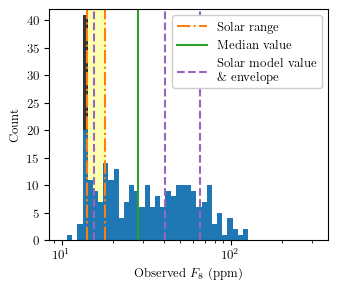

232 stars (84.98%) > Sun-min
212 stars (77.66%) > Sun-med
195 stars (71.43%) > Sun-max
273 stars total


In [45]:
plt.figure(figsize=(FIG_WIDTH, 3))

data = [cat_sn['F8'][cat_sn['F8logg'] != 4.5] * 1000,
        cat_sn['F8'][cat_sn['F8logg'] == 4.5] * 1000]
counts, edges, _ = plt.hist(data, bins=10**np.linspace(1, 2.5), stacked=True, color=["C0", ".2"])

plt.xlabel("Observed $F_8$ (ppm)")
plt.ylabel("Count")
plt.ylim(None, np.max(counts)+1)
plt.xscale('log')

plt.fill_between([0.014*1000, 0.018*1000], [0, 0], [np.max(counts)+1, np.max(counts)+1],
                 zorder=-999, color="yellow", alpha=0.3)
plt.axvline(0.014 * 1000, color="C1", linestyle='-.')
plt.axvline(0.018 * 1000, color="C1", linestyle='-.', label="Solar range")
# plt.fill_betweenx((0, np.max(counts)+1), 0.014 * 1000, 0.018 * 1000, color="C1", alpha=0.5, zorder=10)

sn_median = np.median(cat_sn['F8']) * 1000
plt.axvline(sn_median, color="C2", label="Median value")
print(f"Median flicker: {sn_median:.4g} ppt")

F8_min = base.calc_F8_min(base.logg_sun, base.T_sun, base.M_sun, base.Z_sun, F8_fcn=base.calc_F8)
F8_max = base.calc_F8_max(base.logg_sun, base.T_sun, base.M_sun, base.Z_sun, F8_fcn=base.calc_F8)
F8_middle = base.calc_F8(base.logg_sun, base.T_sun, base.M_sun, base.Z_sun)

plt.axvline(F8_min * 1000, color="C4", linestyle='--')
plt.axvline(F8_max * 1000, color="C4", linestyle='--')
plt.axvline(F8_middle * 1000, color="C4", linestyle='--', label="Solar model value\n\& envelope")

#plt.title(f"Sun-like stars (N={np.sum(sel_sn)}, $\Delta \log g$={delta_logg}, $\Delta T$={delta_T} K)")
plt.legend(handlelength=2.4, framealpha=1)

if save_plots:
    plt.savefig("paper/figures/solar_neighborhood_hist.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()


n_stars = np.sum(sel_sn)
print(f"{np.sum(cat_sn['F8'] > 0.014)} stars ({np.sum(cat_sn['F8'] > 0.014)/n_stars*100:.2f}%) > Sun-min")
print(f"{np.sum(cat_sn['F8'] > 0.016)} stars ({np.sum(cat_sn['F8'] > 0.016)/n_stars*100:.2f}%) > Sun-med")
print(f"{np.sum(cat_sn['F8'] > 0.018)} stars ({np.sum(cat_sn['F8'] > 0.018)/n_stars*100:.2f}%) > Sun-max")
print(f"{n_stars} stars total")

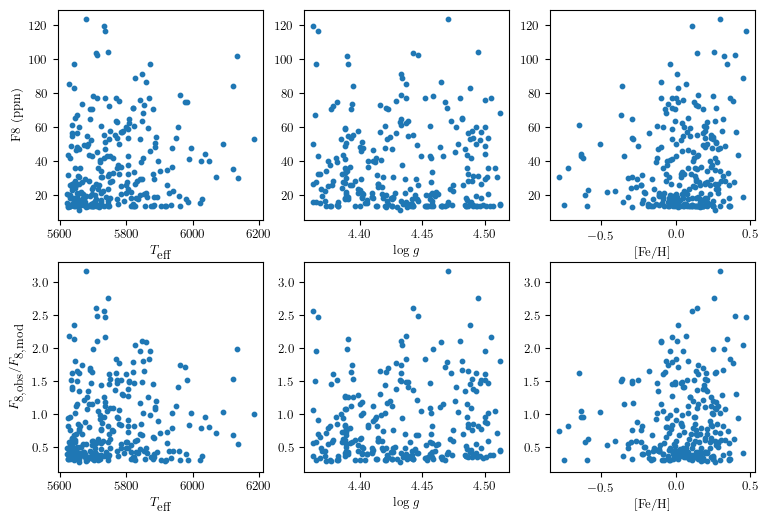

In [46]:
plt.figure(figsize=(9, 6))
plt.subplot(231)
plt.scatter(cat_sn['TeffH'], cat_sn['F8'] * 1000, s=10)
plt.xlabel(r"$T_\textrm{eff}$")
plt.ylabel("F8 (ppm)")

plt.subplot(232)
plt.scatter(cat_sn['loggH'], cat_sn['F8'] * 1000, s=10)
plt.xlabel("log $g$")

plt.subplot(233)
plt.scatter(cat_sn['FeH'], cat_sn['F8'] * 1000, s=10)
plt.xlabel("[Fe/H]")

F8_mod_sn = base.calc_F8(cat_sn['loggH'], cat_sn['TeffH'], cat_sn['MH'], base.FeH_to_Z(cat_sn['FeH']))
plt.subplot(234)
plt.scatter(cat_sn['TeffH'], cat_sn['F8'] / F8_mod_sn, s=10)
plt.xlabel(r"$T_\textrm{eff}$")
plt.ylabel(r"$F_\textrm{8,obs}/F_\textrm{8,mod}$")

plt.subplot(235)
plt.scatter(cat_sn['loggH'], cat_sn['F8'] / F8_mod_sn, s=10)
plt.xlabel("log $g$")

plt.subplot(236)
plt.scatter(cat_sn['FeH'], cat_sn['F8'] / F8_mod_sn, s=10)
plt.xlabel("[Fe/H]");

Neither the observed $F_8$ of these solar-neighborhood stars nor $F_\text{8,obs}/F_\text{8,mod}$ trends with T, logg, or [Fe/H]

# Main sequence slice

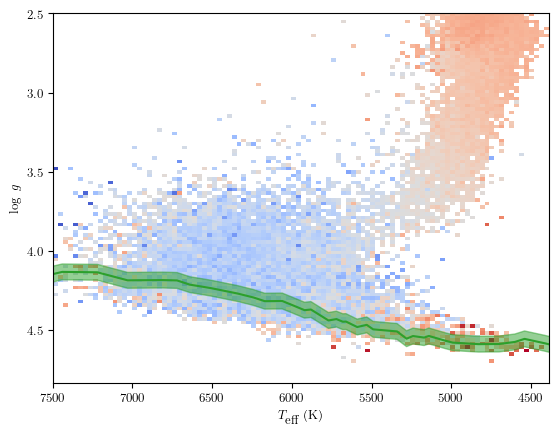

In [47]:
base.plot_quasi_hr(cat, F8_observed / F8_modeled_no_bp_cor, "Observed / modeled $F_8$", cmap='coolwarm',
                   vmin=1e-1, vmax=1e1, log_norm=True,
                   fill_in_bg=False, show_colorbar=False)
plt.plot(msT, mslogg, "C2")
plt.fill_between(msT, mslogg + .05, mslogg - .05, alpha=0.5, color="C2");

That is our slice

In [48]:
Ts = []
ratios = []
orig_ratios = []
for star, ratio, ratio_orig in zip(cat, F8_observed / F8_modeled, F8_observed / F8_modeled_orig):
    i = np.argmin(np.abs(star['TeffH'] - msT))
    if np.abs(star['loggH'] - mslogg[i]) < 0.05:
        Ts.append(star['TeffH'])
        ratios.append(ratio)
        orig_ratios.append(ratio_orig)

## $F_8$ ratios: Paper Figure 6

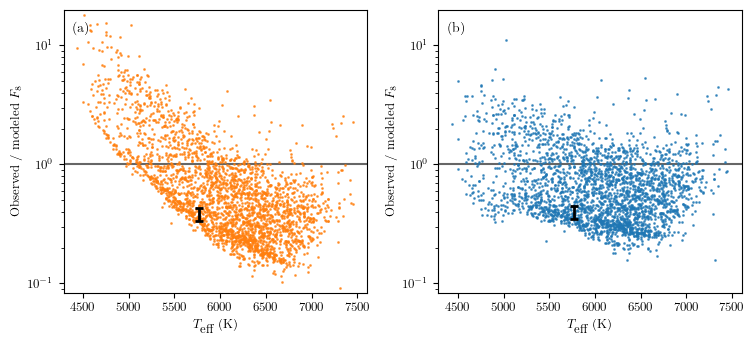

In [49]:
ybounds = 0.9 * np.min(orig_ratios), 1.1 * np.max(orig_ratios)
def make_plot(quantity, color, F8_middle_sun):
    plt.scatter(Ts, quantity, s=1, alpha=0.7, c=color)
    plt.ylim(*ybounds)
    plt.yscale('log')
    plt.xlabel(r"$T_\textrm{eff}$ (K)")
    plt.ylabel("Observed / modeled $F_8$")
    plt.axhline(1, linestyle='-', color='.4', zorder=-99)

    ratio_sun_low = 0.014 / F8_middle_sun
    ratio_sun_med = 0.016 / F8_middle_sun

    plt.errorbar(base.T_sun, ratio_sun_med, ratio_sun_med - ratio_sun_low,
                 color="k", capsize=3, elinewidth=2, capthick=2)

plt.figure(figsize=(WIDE_FIG_WIDTH, 3.5))
plt.subplot(121)
make_plot(orig_ratios, "C1", base.calc_F8_old(base.logg_sun, base.T_sun, base.M_sun))
plt.text(.03, .92, "(a)", fontsize=10, transform=plt.gca().transAxes)

plt.subplot(122)
make_plot(ratios, "C0", base.calc_F8(base.logg_sun, base.T_sun, base.M_sun, base.Z_sun))

plt.text(.03, .92, "(b)", fontsize=10, transform=plt.gca().transAxes)

plt.tight_layout()
if save_plots:
    plt.savefig("paper/figures/ms-slice.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

# Non-correlating quantities

For rotation rate and magnetic activity, we will look for trends both in the full Kepler sample and in the "solar neighborhood" (see above).

## Rotation rate

In [50]:
print(f"{np.sum(catalog['has_M'])} stars in flicker sample with measured PRot")
print(f"{np.sum(cat['has_M'])} stars in joint metallicity-flicker sample with measured PRot")

3954 stars in flicker sample with measured PRot
2820 stars in joint metallicity-flicker sample with measured PRot


### Rotation comparisons: Paper Figure 9

In [51]:
def make_plot(quantity, name, selection, s=0.6, log=True, trend=False):
    x = (F8_observed / F8_modeled)[selection]
    y = quantity[selection]
    if log:
        r, p = scipy.stats.pearsonr(np.log10(x), np.log10(y))
        name = f"log({name})"
    else:
        r, p = scipy.stats.pearsonr(np.log10(x), y)
    print(f"{name} correlation r: {r:.3f}")
    print(f"{name} correlation p: {p:.3f}")
    
    plt.scatter(x, y, s=s, c=cat['TeffH'][selection])
    plt.colorbar().set_label(r"$T_\textrm{eff}$ (K)")
    plt.xscale('log')
    if log:
        plt.yscale('log')
    
    if trend:
        if log:
            y = np.log10(y)
        fit = np.polyfit(np.log10(x), y, 1)
        x = np.linspace(x.min(), x.max())
        ypred = np.polyval(fit, np.log10(x))
        if log:
            ypred = 10**ypred
        plt.plot(x, ypred, 'C1', label='Linear trend line')
        plt.legend(loc='upper right')
    
    plt.xlabel(r"$F_\textrm{8,observed} \; / \; F_\textrm{8,modeled}$")

log(Period) correlation r: -0.114
log(Period) correlation p: 0.000
log(Rossby number) correlation r: 0.025
log(Rossby number) correlation p: 0.185


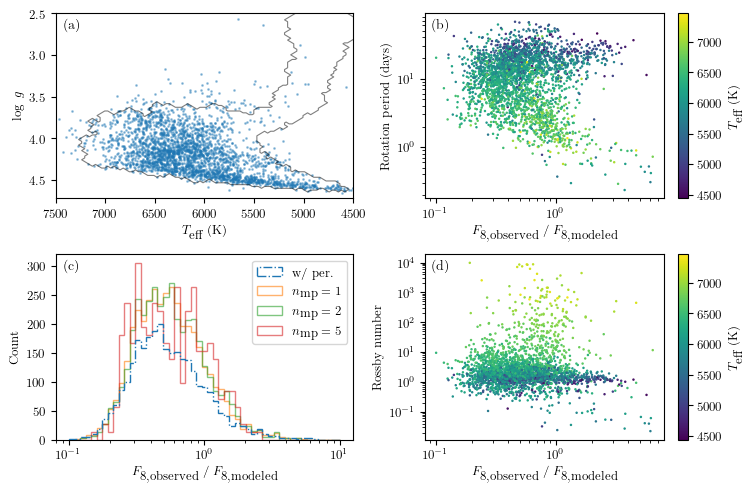

In [52]:
fig = plt.figure(figsize=(WIDE_FIG_WIDTH, 5))

plt.subplot(221)

base.outline_data(cat=cat, linewidths=0.8)
plt.scatter(cat['TeffH'][cat['has_M']], cat['loggH'][cat['has_M']], s=1, alpha=0.4)
plt.xlim(7500, 4500)
plt.ylim(plt.ylim()[1], 2.5)

plt.xlabel(r"$T_\textrm{eff}$ (K)")
plt.ylabel("$\log\ g$")

plt.text(.03, .92, "(a)", fontsize=10, transform=plt.gca().transAxes)



plt.subplot(222)

make_plot(cat['PRot'], "Period", cat['has_M'])
plt.text(.03, .92, "(b)", fontsize=10, transform=plt.gca().transAxes)
plt.ylabel("Rotation period (days)")


plt.subplot(223)

plt.hist((F8_observed / F8_modeled)[cat['has_M']],
         bins=10**np.linspace(-1, 1),
         histtype='step',
         color="C0",
         label='w/ per.',
         linestyle='-.',
         zorder=999999)

stat, r, c, binn = base.prep_2d_bins(cat, cat['has_M'], 'sum')

sel = [stat[r-1, c-1] > 1
       if (0 < r < stat.shape[0]-2 and 0 < c < stat.shape[1]-2)
       else False
       for r, c in zip(*binn)]
sel *= (~cat['has_M'])

plt.hist((F8_observed / F8_modeled)[sel],
         bins=10**np.linspace(-1, 1),
         histtype='step',
         color="C1", alpha=0.6,
         label=r'$n_\textrm{mp}=1$')

sel2 = [stat[r-1, c-1] > 2
        if (0 < r < stat.shape[0]-2 and 0 < c < stat.shape[1]-2)
        else False
        for r, c in zip(*binn)]
sel2 *= (~cat['has_M'])

plt.hist((F8_observed / F8_modeled)[sel2],
         bins=10**np.linspace(-1, 1),
         histtype='step',
         color="C2", alpha=0.6,
         weights=[np.sum(sel) / np.sum(sel2)] * np.sum(sel2),
         label=r'$n_\textrm{mp}=2$')

sel5 = [stat[r-1, c-1] > 5
        if (0 < r < stat.shape[0]-2 and 0 < c < stat.shape[1]-2)
        else False
        for r, c in zip(*binn)]
sel5 *= (~cat['has_M'])

plt.hist((F8_observed / F8_modeled)[sel5],
         bins=10**np.linspace(-1, 1),
         histtype='step',
         color="C3", alpha=0.6,
         weights=[np.sum(sel) / np.sum(sel5)] * np.sum(sel5),
         label=r'$n_\textrm{mp}=5$')

plt.xscale('log')
plt.xlabel(r"$F_\textrm{8,observed} \; / \; F_\textrm{8,modeled}$")
plt.ylabel("Count")

plt.text(.03, .92, "(c)", fontsize=10, transform=plt.gca().transAxes)

plt.legend(loc='upper right')



plt.subplot(224)

rossby = cat['PRot'] / base.calc_convective_turnover_time(cat['TeffH'])
make_plot(rossby, "Rossby number", cat['has_M'])
plt.text(.03, .92, "(d)", fontsize=10, transform=plt.gca().transAxes)
plt.ylabel("Rossby number")


plt.tight_layout()
if save_plots:
    plt.savefig("paper/figures/rot_rate.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

And here is for the solar neighborhood:

72 stars
log(Period) correlation r: -0.080
log(Period) correlation p: 0.505
log(Rossby number) correlation r: -0.068
log(Rossby number) correlation p: 0.568


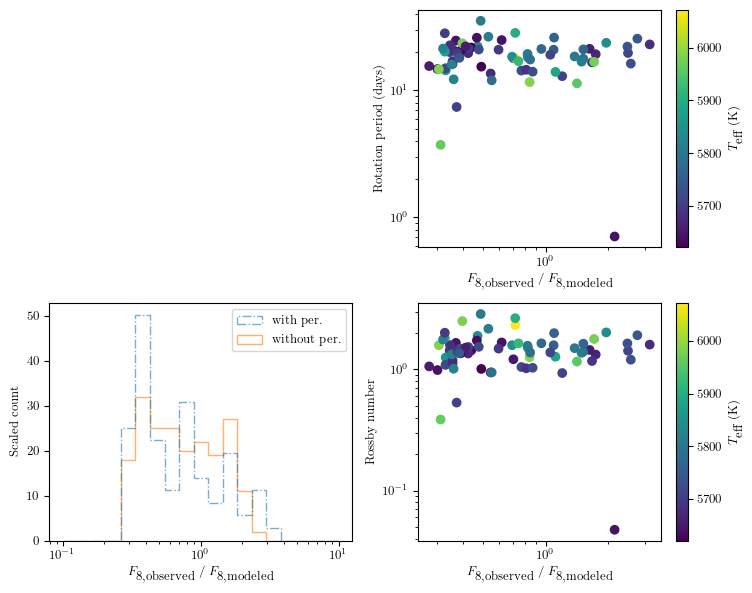

In [53]:
print(f"{np.sum(cat_sn['has_M'])} stars")

plt.figure(figsize=(WIDE_FIG_WIDTH, 6))

plt.subplot(222)

make_plot(cat['PRot'], "Period", cat['has_M'] * sel_sn, s=None)
plt.ylabel("Rotation period (days)")

plt.subplot(224)

make_plot(rossby, "Rossby number", cat['has_M'] * sel_sn, s=None)
plt.ylabel("Rossby number")

plt.subplot(223)

plt.hist((F8_observed / F8_modeled)[sel_sn][cat_sn['has_M']],
         bins=10**np.linspace(-1, 1, 20),
         histtype='step',
         color="C0", alpha=0.6,
         label='with per.',
         linestyle='-.',
         weights=[np.sum(~cat_sn['has_M']) / np.sum(cat_sn['has_M'])] * np.sum(cat_sn['has_M']),
         zorder=999999)

plt.hist((F8_observed / F8_modeled)[sel_sn][~cat_sn['has_M']],
         bins=10**np.linspace(-1, 1, 20),
         histtype='step',
         color="C1", alpha=0.6,
         label=r'without per.')

plt.xscale('log')
plt.xlabel(r"$F_\textrm{8,observed} \; / \; F_\textrm{8,modeled}$")
plt.ylabel("Scaled count")

plt.legend()

plt.tight_layout()

## Magnetic activity indices

In [54]:
print(f"{np.sum(catalog['has_Z'])} stars in flicker sample with measured mag. activity indices")
print(f"{np.sum(cat['has_Z'])} stars in joint metallicity-flicker sample with measured mag. activity indices")

2021 stars in flicker sample with measured mag. activity indices
1895 stars in joint metallicity-flicker sample with measured mag. activity indices


### Rotation activity comparisons: Paper Figure 10

S correlation r: 0.119
S correlation p: 0.000
log(R+HK) correlation r: -0.011
log(R+HK) correlation p: 0.619
log(Reff) correlation r: 0.115
log(Reff) correlation p: 0.000


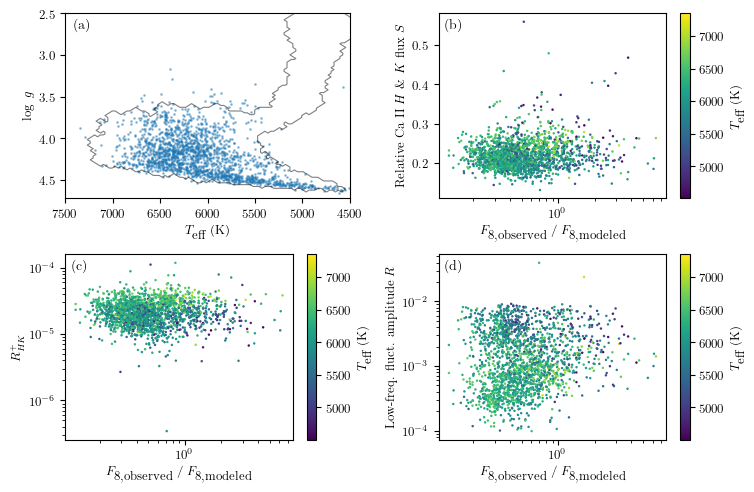

In [55]:
plt.figure(figsize=(WIDE_FIG_WIDTH, 5))

plt.subplot(221)

base.outline_data(cat=cat, linewidths=0.8)
plt.scatter(cat['TeffH'][cat['has_Z']], cat['loggH'][cat['has_Z']], s=1, alpha=0.4)
plt.xlim(7500, 4500)
plt.ylim(plt.ylim()[1], 2.5)

plt.xlabel(r"$T_\textrm{eff}$ (K)")
plt.ylabel("$\log\ g$")

plt.text(.03, .92, "(a)", fontsize=10, transform=plt.gca().transAxes)



plt.subplot(222)

make_plot(cat['S'], "S", cat['has_Z'], log=False)
plt.ylabel("Relative Ca II $H$ \& $K$ flux $S$")
plt.text(.03, .92, "(b)", fontsize=10, transform=plt.gca().transAxes)


plt.subplot(223)

make_plot(10**cat['logR+HK'], "R+HK", cat['has_Z'])
plt.ylabel(r"$R^+_{HK}$")
plt.text(.03, .92, "(c)", fontsize=10, transform=plt.gca().transAxes)


plt.subplot(224)

make_plot(cat['Reff'], "Reff", cat['has_Z'])
plt.ylabel(r"Low-freq. fluct. amplitude $R$")
plt.text(.03, .92, "(d)", fontsize=10, transform=plt.gca().transAxes)


plt.tight_layout()
if save_plots:
    plt.savefig("paper/figures/mag_indices.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

And here is for the solar neighborhood:

53 stars
S correlation r: -0.344
S correlation p: 0.012
log(R+HK) correlation r: -0.396
log(R+HK) correlation p: 0.003
log(Reff) correlation r: -0.178
log(Reff) correlation p: 0.203


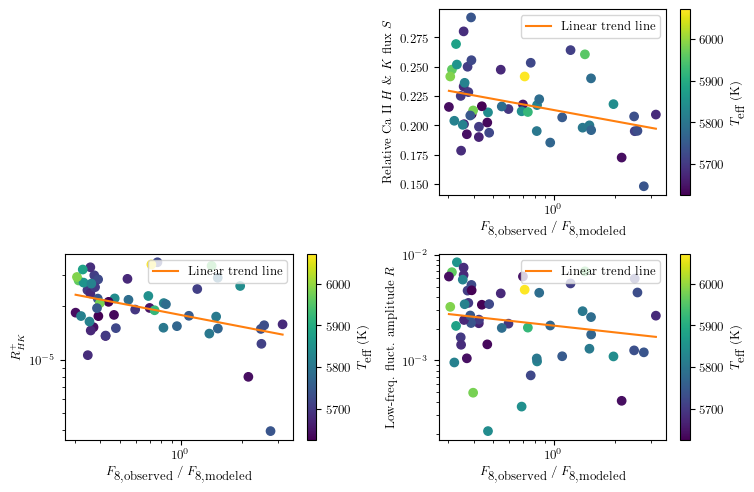

In [56]:
print(f"{np.sum(cat_sn['has_Z'])} stars")

plt.figure(figsize=(WIDE_FIG_WIDTH, 5))

plt.subplot(222)

make_plot(cat['S'], "S", cat['has_Z']*sel_sn, s=None, trend=True, log=False)
plt.ylabel("Relative Ca II $H$ \& $K$ flux $S$")


plt.subplot(223)

make_plot(10**cat['logR+HK'], "R+HK", cat['has_Z']*sel_sn, s=None, trend=True)
plt.ylabel(r"$R^+_{HK}$")

plt.subplot(224)

make_plot(cat['Reff'], "Reff", cat['has_Z']*sel_sn, s=None, trend=True)
plt.ylabel(r"Low-freq. fluct. amplitude $R$")
plt.xlim(None, None)
plt.ylim(None, None)

plt.tight_layout()

## Identified binary stars: Paper Figure 11

73 known binaries in full catalog
48 known binaries with metallicity
Mean ratio: 0.296
t test p-value under H0 = "The mean log(ratio) is zero": 9e-09


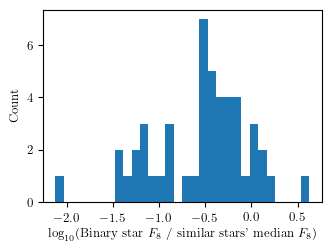

In [57]:
plt.figure(figsize=(FIG_WIDTH, 2.5))

KIC, period = np.genfromtxt("orig_data/Kirk_2016.txt", delimiter=',', skip_header=8, usecols=(0, 1), unpack=True)
KIC = KIC.astype(int)
is_binary = np.array([kic in KIC for kic in catalog['KIC']])
print(f"{np.sum(is_binary)} known binaries in full catalog")
is_binary = np.array([kic in KIC for kic in cat['KIC']])
print(f"{np.sum(is_binary)} known binaries with metallicity")

# Look for neighbor stars w/in this range of each known binary
dT = 100
dlogg = 0.05

ratios = []
neighbor_count = []
for kic in cat['KIC'][is_binary]:
    i = np.where(cat['KIC'] == kic)
    T = cat['TeffH'][i]
    logg = cat['loggH'][i]
    neighbors = (cat['loggH'] < (logg+dlogg)) * (cat['loggH'] > (logg-dlogg)) * (cat['Teff'] < (T+dT)) * (cat['TeffH'] > (T-dT))
    avg_flicker = np.median(cat['F8'][neighbors])
    ratios.append(cat['F8'][i] / avg_flicker)
    neighbor_count.append(np.sum(neighbors))

plt.hist(np.squeeze(np.log(ratios)), bins=30)

mean = 10**np.mean(np.log(ratios))
print(f"Mean ratio: {mean:.3f}")

plt.xlabel(r"$\log_{10}$(Binary star $F_8$ / similar stars' median $F_8$)")
plt.ylabel("Count")

ttest_res = scipy.stats.ttest_1samp(np.log2(ratios), 0)
print(f"t test p-value under H0 = \"The mean log(ratio) is zero\": {ttest_res.pvalue[0]:.2g}")

if save_plots:
    plt.savefig("paper/figures/binaries.pdf", bbox_inches='tight', pad_inches=0)
plt.show()